# Turnover des collaborateurs à l'Assemblée Nationale

## Introduction

Cet étude est basée sur les listes de collaborateurs par députés [publiées par l'Assemblée Nationale](http://www2.assemblee-nationale.fr/qui/liste-des-collaborateurs-par-depute), collectées et transformées par [Regards Citoyens](https://github.com/regardscitoyens/Collaborateurs-Parlement), puis concaténées et opérationnalisées par nos soins.

Elle cherche à quantifier la rotation de l'emploi, ou _turnover_, des collaborateurs en analysant la durée de leurs contrats de travail, ainsi que les caractéristiques des parlementaires qui les emploient.

Nous employons des méthodes issues des statistiques descriptive et inférentielle pour tenter de comprendre s'il existe des profils de collaborations entre les parlementaires et les assistants qu'ils emploient.

## Préparation des données

In [76]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, linregress

# Fichier généré quotidiennenement par nosdeputes.fr depuis le site de l'AN
csv = pd.read_csv("../data/turnover.csv", encoding='utf-8')

csv["groupes_majoritaires"] = (csv["groupe_sigle"] == "LREM") | (csv["groupe_sigle"] == "MODEM")

# Parsing des dates de contrat, de mandat et de naissance
csv["entree"] = pd.to_datetime(csv["entree"])
csv["sortie"] = pd.to_datetime(csv["sortie"])
csv["mandat_debut"] = pd.to_datetime(csv["mandat_debut"])
csv["mandat_fin"] = pd.to_datetime(csv["mandat_fin"])
csv["date_naissance"] = pd.to_datetime(csv["date_naissance"])

# Calcul des temps de contrat, de mandat et de l'âge
csv["contrat_fini"] = (csv["mandat_fin"] - csv["sortie"]).astype(int) > 10000000000000
csv["duree_mandat"] = csv["mandat_fin"] - csv["mandat_debut"]
csv["duree_mandat"] = csv["duree_mandat"].apply(lambda a: int(a.total_seconds()/60/60/24))
csv["parlementaire_age"] = (max(csv["sortie"]) - csv['date_naissance']).apply(lambda a: int(a.total_seconds()/60/60/24/365))

# Calcul du nombre de contrats courts par parlementaire
csv["contrat_plus_de_2_mois"] = (( (csv["nombredejours"] < 62) & (csv["contrat_fini"] == True)  ) == False) * 1 
csv["contrat_plus_de_4_mois"] = (( (csv["nombredejours"] < 124) & (csv["contrat_fini"] == True) ) == False) * 1
csv["contrat_plus_de_6_mois"] = (( (csv["nombredejours"] < 186) & (csv["contrat_fini"] == True) ) == False) * 1

#Preparation indicateur Rotation de l'emploi
#https://fr.wikipedia.org/wiki/Rotation_de_l%27emploi
date_rotation_un_an = "2017-10-01"
csv["contrat_present_a_date_rotation_un_an"] = (csv["entree"] <= date_rotation_un_an) & (csv["sortie"] > date_rotation_un_an)
csv["contrat_entree_depuis_date_rotation_un_an"] = (csv["entree"] > date_rotation_un_an)
csv["contrat_sortie_depuis_date_rotation_un_an"] = (csv["sortie"] > date_rotation_un_an) & (csv["sortie"] < max(csv["sortie"]))
date_rotation_six_mois = "2018-04-01"
csv["contrat_present_a_date_rotation_six_mois"] = (csv["entree"] <= date_rotation_six_mois) & (csv["sortie"] > date_rotation_six_mois)
csv["contrat_entree_depuis_date_rotation_six_mois"] = (csv["entree"] > date_rotation_six_mois)
csv["contrat_sortie_depuis_date_rotation_six_mois"] = (csv["sortie"] > date_rotation_six_mois) & (csv["sortie"] < max(csv["sortie"]))

csv["contrat_present_a_date_rotation_six_premiers_mois"] = csv["contrat_present_a_date_rotation_un_an"]
csv["contrat_entree_depuis_date_rotation_six_premiers_mois"] = (csv["entree"] > date_rotation_un_an) & (csv["entree"] < date_rotation_six_mois)
csv["contrat_sortie_depuis_date_rotation_six_premiers_mois"] = (csv["sortie"] > date_rotation_un_an) & (csv["sortie"] < date_rotation_six_mois)


# Suppression des contrat inférieur à 7 jours (problème liés aux ministres)
csv = csv[csv["nombredejours"] > 7]

# Suppression des contrats courts de début de législature (fin de contrat de la législature précédente)
csv = csv[(csv["entree"] < "2017-09-01") & (csv["nombredejours"] < 30) == False]
# Supression des députés plus en mandat
csv = csv[csv["mandat_fin"] == max(csv["mandat_fin"])]
csv = csv[csv["mandat_debut"] < date_rotation_un_an]

# Suppression des colonnes inutiles du fichiers d'entrée
csv.drop("collaborateurs", 1, inplace=True)

### Contrôle

In [27]:
csv.head()

,parlementaire,nom_parlementaire,prénom_parlementaire,sexe_parlementaire,collaborateur,nom_collaborateur,prénom_collaborateur,sexe_collaborateur,url_nosdeputes_api,url_institution,...,contrat_plus_de_6_mois,contrat_present_a_date_rotation_un_an,contrat_entree_depuis_date_rotation_un_an,contrat_sortie_depuis_date_rotation_un_an,contrat_present_a_date_rotation_six_mois,contrat_entree_depuis_date_rotation_six_mois,contrat_sortie_depuis_date_rotation_six_mois,contrat_present_a_date_rotation_six_premiers_mois,contrat_entree_depuis_date_rotation_six_premiers_mois,contrat_sortie_depuis_date_rotation_six_premiers_mois
0,Louis Aliot,Aliot,Louis,H,Mme Rania Messiha,Messiha,Rania,F,https://www.nosdeputes.fr/louis-aliot/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,True,False,False,True,False,False,True,False,False
1,Bertrand Bouyx,Bouyx,Bertrand,H,M. Hugo Guillochin,Guillochin,Hugo,H,https://www.nosdeputes.fr/bertrand-bouyx/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,True,False,False,True,False,False,True,False,False
2,Stéphane Buchou,Buchou,Stéphane,H,Mme Claire Legrand,Legrand,Claire,F,https://www.nosdeputes.fr/stephane-buchou/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,True,False,False,True,False,False,True,False,False
3,Cédric Roussel,Roussel,Cédric,H,Mme Caroline Puisségur-Ripet,Puisségur-Ripet,Caroline,F,https://www.nosdeputes.fr/cedric-roussel/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,False,True,False,True,False,False,False,True,False
4,Isabelle Valentin,Valentin,Isabelle,F,Mme Céline Saby,Saby,Céline,F,https://www.nosdeputes.fr/isabelle-valentin/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,True,False,False,True,False,False,True,False,False


Nombre de collarateurs :

In [28]:
len(csv['collaborateur'].unique())

2746

Nombre de collaborateurs en cours de contrat :

In [29]:
((csv['contrat_fini']  != True) * 1).sum()

1991

ratio des parlementaires des groupes majoritaires

In [31]:
len(csv[csv["groupes_majoritaires"]]["parlementaire"].unique())/len(csv["parlementaire"].unique())

0.6294326241134752

# Rotation de l'emploi au niveau global

La rotation de l'emploi, ou renouvellement du personnel, est [définie comme suit](https://fr.wikipedia.org/wiki/Rotation_de_l%27emploi) : ((recrutements + fins de contrats) / 2) / nombre d'emplois en début de période.

Celle de l'ensemble des collaborateurs de l'Assemblée sur l'année est de 65.5%. D'après une étude de la [DARES de 2011](http://travail-emploi.gouv.fr/IMG/pdf/2012-056.pdf), ce taux est sensiblement identique au taux national français pour des emplois du tertiaires (64%).

In [74]:
(((csv["contrat_entree_depuis_date_rotation_un_an"]*1).sum()+(csv["contrat_sortie_depuis_date_rotation_un_an"]*1).sum())/2)/((csv["contrat_present_a_date_rotation_un_an"]*1).sum())

0.6550751879699248

# Collaborateur : une profession précaire ?

Durée moyenne d'un contrat (contrat en cours inclus) :

In [30]:
csv["nombredejours"].mean()/30.5

8.986618859483974

## Durée des contrats

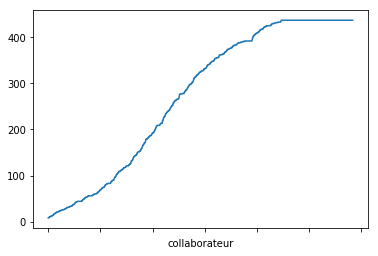

In [40]:
contrats = csv[["nombredejours", "collaborateur"]].reset_index()[["nombredejours", "collaborateur"]]
contrats.index = contrats["collaborateur"]
contrats["nombredejours"].sort_values().plot()

In [41]:
contrats.groupby("nombredejours").count().sort_values(by="collaborateur", ascending=False).head(10)

,collaborateur
nombredejours,
437.0,687
392.0,69
44.0,42
56.0,39
425.0,37
83.0,28
209.0,25
433.0,24
432.0,23


Les seuls paliers notables :

 - début de mandat et contrat en cours (437 j)
 - suppléant suite nommination gouv (392 j)

## Description générale du comportement individuel des députés

### Préparation des données

In [42]:
duree_collaborateurs = csv.groupby(["parlementaire"])[['groupe_sigle']].first().reset_index()
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['sexe_parlementaire']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nom_circo']].first().rename(columns={"nom_circo": "departement"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].median().rename(columns={"nombredejours": "contrat_mediane"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].mean().rename(columns={"nombredejours": "contrat_moyenne"}).reset_index(), on="parlementaire")

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['collaborateur']].count().rename(columns={"collaborateur": "nb_collaborateurs_total"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['duree_mandat']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_max"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_min"}).reset_index(), on="parlementaire")

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_2_mois']].sum().rename(columns={"contrat_plus_de_2_mois": "nb_contrats_plus_de_2_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_2_mois'] = duree_collaborateurs['nb_contrats_plus_de_2_mois'] / duree_collaborateurs['nb_collaborateurs_total']
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_4_mois']].sum().rename(columns={"contrat_plus_de_4_mois": "nb_contrats_plus_de_4_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_4_mois'] = duree_collaborateurs['nb_contrats_plus_de_4_mois'] / duree_collaborateurs['nb_collaborateurs_total']
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_6_mois']].sum().rename(columns={"contrat_plus_de_6_mois": "nb_contrats_plus_de_6_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_6_mois'] = duree_collaborateurs['nb_contrats_plus_de_6_mois'] / duree_collaborateurs['nb_collaborateurs_total']

duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].count().rename(columns={"nombredejours": "nb_contrat_fini"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs['nb_contrat_fini'].fillna(0, inplace=True)
duree_collaborateurs['ratio_contrat_fini'] = duree_collaborateurs['nb_contrat_fini'] / duree_collaborateurs['nb_collaborateurs_total']

duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_fini_max"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_fini_min"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['ancien_depute']].first().reset_index(), on="parlementaire")
duree_collaborateurs["ratio_contrat_mandat"] = duree_collaborateurs["contrat_mediane"] / duree_collaborateurs["duree_mandat"]
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nb_mandats']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['parlementaire_age']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.sort_values("ratio_plus_de_2_mois")#sort_values("contrat le plus long")

#Rotation emploi
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_present_a_date_rotation_un_an', 'contrat_entree_depuis_date_rotation_un_an', 'contrat_sortie_depuis_date_rotation_un_an']].sum().reset_index(), on="parlementaire")
duree_collaborateurs['contrat_present_moyen'] = (duree_collaborateurs['contrat_present_a_date_rotation_un_an'] + duree_collaborateurs['nb_collaborateurs_total'] - duree_collaborateurs['nb_contrat_fini']) / 2
duree_collaborateurs["emploi_rotation_un_an"] =  ((duree_collaborateurs['contrat_entree_depuis_date_rotation_un_an']+duree_collaborateurs['contrat_sortie_depuis_date_rotation_un_an'])/2)/duree_collaborateurs['contrat_present_moyen']
duree_collaborateurs["emploi_taux_depart_un_an"]   =  duree_collaborateurs['contrat_sortie_depuis_date_rotation_un_an']/duree_collaborateurs['contrat_present_moyen']
duree_collaborateurs["emploi_taux_arrivee_un_an"] =  duree_collaborateurs['contrat_entree_depuis_date_rotation_un_an']/duree_collaborateurs['contrat_present_moyen']

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_present_a_date_rotation_six_mois', 'contrat_entree_depuis_date_rotation_six_mois', 'contrat_sortie_depuis_date_rotation_six_mois']].sum().reset_index(), on="parlementaire")
duree_collaborateurs["emploi_rotation_six_mois"] =  ((duree_collaborateurs['contrat_entree_depuis_date_rotation_six_mois']+duree_collaborateurs['contrat_sortie_depuis_date_rotation_six_mois'])/2)/duree_collaborateurs['contrat_present_a_date_rotation_six_mois']
duree_collaborateurs["emploi_taux_depart_six_mois"]   =  duree_collaborateurs['contrat_sortie_depuis_date_rotation_six_mois']/duree_collaborateurs['contrat_present_a_date_rotation_six_mois']
duree_collaborateurs["emploi_taux_arrivee_six_mois"] =  duree_collaborateurs['contrat_entree_depuis_date_rotation_six_mois']/duree_collaborateurs['contrat_present_a_date_rotation_six_mois']

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_present_a_date_rotation_six_premiers_mois', 'contrat_entree_depuis_date_rotation_six_premiers_mois', 'contrat_sortie_depuis_date_rotation_six_premiers_mois']].sum().reset_index(), on="parlementaire")
duree_collaborateurs["emploi_rotation_six_premiers_mois"] =  ((duree_collaborateurs['contrat_entree_depuis_date_rotation_six_premiers_mois']+duree_collaborateurs['contrat_sortie_depuis_date_rotation_six_premiers_mois'])/2)/duree_collaborateurs['contrat_present_a_date_rotation_six_premiers_mois']
duree_collaborateurs["emploi_taux_depart_six_premiers_mois"]   =  duree_collaborateurs['contrat_sortie_depuis_date_rotation_six_premiers_mois']/duree_collaborateurs['contrat_present_a_date_rotation_six_premiers_mois']
duree_collaborateurs["emploi_taux_arrivee_six_premiers_mois"] =  duree_collaborateurs['contrat_entree_depuis_date_rotation_six_premiers_mois']/duree_collaborateurs['contrat_present_a_date_rotation_six_premiers_mois']


duree_collaborateurs.to_csv("../data/duree_collaborateur.csv")

### Durée des contrats de collaborateurs

Certains députés ont des collaborateurs fidèles. Le graphique suivant représente le contrat le plus long de chacun des parlementaires. Les _fidèles_ sont représentés par le palier supérieur à droite : la durée de leur contrat est égale à la durée de la législature.

On observe un second palier plus réduit à 300 jours, il représente probablement les fidèles des parlementaires suppléants de ministre du gouvernement Philippe 1.

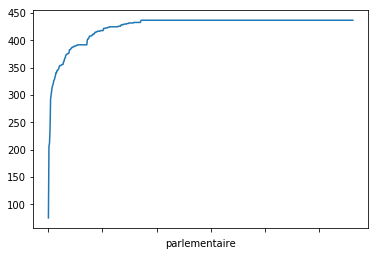

In [43]:
duree_collaborateurs.sort_values("contrat_max").set_index("parlementaire")["contrat_max"].plot()

Le graphique infra représente le contrat le plus court pour chacun des parlementaires.

Rares sont les parlementaire qui ont conservé leur staff tout le long de la 1ère année.

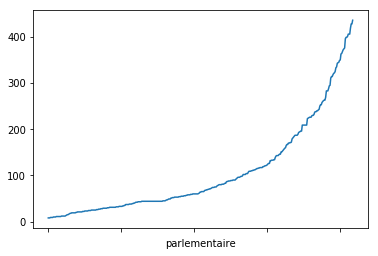

In [44]:
duree_collaborateurs.sort_values("contrat_fini_min").set_index("parlementaire")["contrat_fini_min"].plot()

Plus de la moitié des parlementaires ont déjà mis fin à un contrat dans une durée de moins de 4 mois.

In [45]:
duree_collaborateurs[duree_collaborateurs["contrat_fini_min"] < 122]["parlementaire"].count() * 100 / duree_collaborateurs["parlementaire"].count()

53.01418439716312

# Effet politique ?

## L'influence des groupes politiques

Les durées moyennes de contrat par groupe politique pointe les non-inscrits comme le groupe parlementaire qui garde le moins longtemps ses collaborateurs.

In [52]:
duree_collaborateurs[["groupe_sigle", "contrat_mediane"]].groupby("groupe_sigle").mean().sort_values("contrat_mediane")

,contrat_mediane
groupe_sigle,
NI,279.300000
LREM,299.726537
MODEM,305.500000
UAI,319.725806
LR,333.515152
GDR,350.566667
NG,353.925926
LFI,354.941176


In [53]:
duree_collaborateurs[["groupe_sigle", "emploi_rotation_un_an", "emploi_taux_depart_un_an"]].groupby("groupe_sigle").mean().sort_values("emploi_taux_depart_un_an", ascending=False)

,emploi_rotation_un_an,emploi_taux_depart_un_an
groupe_sigle,,
NI,0.821616,0.672908
MODEM,0.623879,0.529848
LREM,0.665811,0.528921
NG,0.462375,0.433451
LR,0.548385,0.425394
LFI,0.448599,0.421895
UAI,0.511642,0.404692
GDR,0.533598,0.348889


# Effet de genre ?

# L'influence du sexe

Les durées médianes des contrats de collaborateurs femmes et hommes indiquent que les femmes restent en poste sensiblement plus longtemps, alors que collaborer avec une parlementaire femme mène à des contrats plus courts.

In [54]:
collab_femme_vs_homme = csv.groupby(["sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].median().sort_values("nombredejours")
collab_femme_vs_homme

,nombredejours
sexe_collaborateur,
H,308.0
F,333.0


In [55]:
depute_femme_vs_homme = csv.groupby(["sexe_parlementaire"])[['nombredejours', 'sexe_collaborateur']].median().sort_values("nombredejours")
depute_femme_vs_homme

,nombredejours
sexe_parlementaire,
F,280.0
H,348.0


On observe que seules les parlementaires femmes montrent une préférences de genre envers les hommes pour leurs collaborateurs, mais cela n'influe pas sur la durée des contrats des collaborateurs.

In [56]:
duree_moy_sexe = csv.groupby(["parlementaire", "sexe_parlementaire", "sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].mean()
nb_collab_sexe = csv.groupby(["parlementaire", "sexe_collaborateur"])[['collaborateur']].count().rename(columns={'collaborateur': 'nb_collaborateurs'})
stats_sexe = duree_moy_sexe.reset_index().merge(nb_collab_sexe.reset_index(), on=["parlementaire", "sexe_collaborateur"])
stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nombredejours"]].mean().sort_values("nombredejours")

nombredejours
sexe_parlementaire sexe_collaborateur               
F                  H                      270.750812
                   F                      291.696166
H                  H                      300.631052
                   F                      311.091747

In [57]:
nb = stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nb_collaborateurs"]].sum()
moy = stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nb_collaborateurs"]].mean()["nb_collaborateurs"].rename(columns={"nb_collaborateurs": "nb_collaborateurs_moyen"})

moy.reset_index().merge(nb.reset_index(), on=["sexe_parlementaire", "sexe_collaborateur"]).set_index(["sexe_parlementaire", "sexe_collaborateur"]).rename(columns={0 : 'nb collaborateurs moyen'})


nb collaborateurs moyen  \
sexe_parlementaire sexe_collaborateur                            
F                  F                                  2.741784   
                   H                                  2.863850   
H                  F                                  2.649390   
                   H                                  2.652174   

                                       nb_collaborateurs  
sexe_parlementaire sexe_collaborateur                     
F                  F                                 584  
                   H                                 610  
H                  F                                 869  
                   H                                 854

## Tests statistiques sur les parlementaires

### Préparation des données

In [58]:
# Dichotomisation des variables
duree_tt = duree_collaborateurs
duree_tt["parlementaire_femme"] = (duree_tt["sexe_parlementaire"] == "F") * 1
duree_tt["parlementaire_homme"] = (duree_tt["sexe_parlementaire"] == "H") * 1
duree_tt["parlementaire_has_autre_mandats"] = (duree_tt["nb_mandats"] > 1) * 1
duree_tt["ancien_depute"] = (duree_tt["ancien_depute"]) * 1
for grp in duree_tt["groupe_sigle"].unique():
    duree_tt["groupe_"+grp] = (duree_tt["groupe_sigle"] == grp) * 1

# Inputation des valeurs manquantes
duree_tt["contrat_fini_min"].fillna(150, inplace=True)
duree_tt["contrat_fini_max"].fillna(150, inplace=True)

### Test de significativité des variables dichotomiques

Pour chacune des variables booléennes décrivant les parlementaires (sexe, groupes, etc.) on effectue un test indiquant son effet sur la durée moyenne des contrats de ses collaborateurs.

In [59]:
for i in duree_tt.drop(["contrat_present_a_date_rotation_un_an", "contrat_entree_depuis_date_rotation_un_an", "contrat_sortie_depuis_date_rotation_un_an", "contrat_present_moyen", "emploi_rotation_un_an", "emploi_taux_depart_un_an", "emploi_taux_arrivee_un_an", "contrat_present_a_date_rotation_six_mois", "contrat_entree_depuis_date_rotation_six_mois", "contrat_sortie_depuis_date_rotation_six_mois", "emploi_rotation_six_mois", "emploi_taux_depart_six_mois", "emploi_taux_arrivee_six_mois", "contrat_present_a_date_rotation_six_premiers_mois", "contrat_entree_depuis_date_rotation_six_premiers_mois", "contrat_sortie_depuis_date_rotation_six_premiers_mois", "emploi_rotation_six_premiers_mois", "emploi_taux_depart_six_premiers_mois", "emploi_taux_arrivee_six_premiers_mois", "nb_contrat_fini", "ratio_contrat_fini","contrat_mediane", "contrat_moyenne", "nb_collaborateurs_total", "parlementaire_age", "duree_mandat", "nb_mandats","contrat_max", "contrat_min", "ratio_contrat_mandat", "contrat_fini_max", "contrat_fini_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois","nb_contrats_plus_de_4_mois","ratio_plus_de_4_mois","nb_contrats_plus_de_6_mois","ratio_plus_de_6_mois"], 1).columns[4:]:
    cat2 = duree_tt[duree_tt[i] == 0]["contrat_moyenne"]
    cat1 = duree_tt[duree_tt[i] == 1]["contrat_moyenne"]

    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

ancien_depute : 2.908406, 0.003776

parlementaire_femme : -3.950488, 0.000088

parlementaire_homme : 3.950488, 0.000088

parlementaire_has_autre_mandats non significatif

groupe_MODEM non significatif

groupe_LR : 1.862781, 0.063015

groupe_LREM : -3.165727, 0.001631

groupe_UAI non significatif

groupe_NG : 1.288869, 0.197974

groupe_NI non significatif

groupe_LFI : 1.565531, 0.118021

groupe_GDR non significatif



### Tests de régression sur les variables continues

Pour les deux variables continues, l'âge et le nombre de mandats, décrivant les parlementaires, on effectue un test de régression qui nous indique son effet sur la durée moyenne de ses contrats.

nb_mandats : non significatif

parlementaire_age : slope:0.018010, intercept:44.639212, 
	rvalue:0.127207, pvalue:0.002473, stderr:0.002473



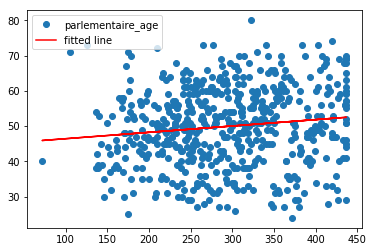

In [68]:
tt = {}
for i in duree_tt.columns[4:].drop(["ancien_depute", "parlementaire_femme", "parlementaire_homme", "groupe_LR", "groupe_LREM", "groupe_MODEM", "groupe_UAI", "groupe_NG", "groupe_NI", "groupe_LFI", "groupe_GDR", "nb_collaborateurs_total", "contrat_max", "contrat_min", "nb_contrats_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "nb_contrat_fini", "contrat_fini_max", "contrat_fini_min", "ratio_contrat_mandat", "contrat_present_a_date_rotation_un_an", "contrat_entree_depuis_date_rotation_un_an", "contrat_sortie_depuis_date_rotation_un_an", "contrat_present_moyen", "emploi_rotation_un_an", "emploi_taux_depart_un_an", "emploi_taux_arrivee_un_an", "contrat_present_a_date_rotation_six_mois", "contrat_entree_depuis_date_rotation_six_mois", "contrat_sortie_depuis_date_rotation_six_mois", "emploi_rotation_six_mois", "emploi_taux_depart_six_mois", "emploi_taux_arrivee_six_mois", "contrat_present_a_date_rotation_six_premiers_mois", "contrat_entree_depuis_date_rotation_six_premiers_mois", "contrat_sortie_depuis_date_rotation_six_premiers_mois", "emploi_rotation_six_premiers_mois", "emploi_taux_depart_six_premiers_mois", "emploi_taux_arrivee_six_premiers_mois", "contrat_moyenne", "contrat_mediane", "duree_mandat", "ratio_plus_de_2_mois", "ratio_plus_de_4_mois", "ratio_plus_de_6_mois", "ratio_contrat_fini", "parlementaire_has_autre_mandats"], 1):
    tt[i] = linregress(duree_tt["contrat_moyenne"], duree_tt[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(duree_tt["contrat_moyenne"], duree_tt[i], 'o', label=i)
        plt.plot(duree_tt["contrat_moyenne"], tt[i].intercept + tt[i].slope*duree_tt["contrat_moyenne"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")

## Tests statistiques sur les collaborateurs

### Préparation des données

In [61]:
tous_collaborateurs = csv.merge(duree_collaborateurs.drop([ 'groupe_sigle', 'sexe_parlementaire', 'duree_mandat', 'nb_mandats', 'parlementaire_age', 'ancien_depute'], 1), on="parlementaire")
tous_collaborateurs["collaborateur_femme"] = (tous_collaborateurs["sexe_collaborateur"] == "F") * 1
tous_collaborateurs["collaborateur_homme"] = (tous_collaborateurs["sexe_collaborateur"] == "H") * 1
tous_collaborateurs.to_csv("../data/turnover_collaborateurs_variables.csv")
tous_collaborateurs = tous_collaborateurs.drop(["entree", "sortie"], 1)

tous_collaborateurs = tous_collaborateurs.drop(['groupe_sigle', 'parti_ratt_financier', 'sites_web','emails', 'adresses', 'autres_mandats', 'anciens_autres_mandats', 'anciens_mandats', 'profession', 'place_en_hemicycle', 'url_an', 'id_an', 'slug', 'url_nosdeputes', "duree_mandat", "departement"], 1)
#tous_collaborateurs.columns[24:]

### Test de significativité des variables dichotomiques

In [69]:
for i in tous_collaborateurs.columns[24:].drop(["contrat_present_a_date_rotation_un_an_x", "contrat_entree_depuis_date_rotation_un_an_x", "contrat_sortie_depuis_date_rotation_un_an_x", "contrat_present_a_date_rotation_six_mois_x", "contrat_entree_depuis_date_rotation_six_mois_x", "contrat_sortie_depuis_date_rotation_six_mois_x", "contrat_present_a_date_rotation_six_premiers_mois_x", "contrat_entree_depuis_date_rotation_six_premiers_mois_x", "contrat_sortie_depuis_date_rotation_six_premiers_mois_x", "contrat_present_a_date_rotation_un_an_y", "contrat_entree_depuis_date_rotation_un_an_y", "contrat_sortie_depuis_date_rotation_un_an_y", "contrat_present_moyen", "emploi_rotation_un_an", "emploi_taux_depart_un_an", "emploi_taux_arrivee_un_an", "contrat_present_a_date_rotation_six_mois_y", "contrat_entree_depuis_date_rotation_six_mois_y", "contrat_sortie_depuis_date_rotation_six_mois_y", "emploi_rotation_six_mois", "emploi_taux_depart_six_mois", "emploi_taux_arrivee_six_mois", "contrat_present_a_date_rotation_six_premiers_mois_y", "contrat_entree_depuis_date_rotation_six_premiers_mois_y", "contrat_sortie_depuis_date_rotation_six_premiers_mois_y", "emploi_rotation_six_premiers_mois", "emploi_taux_depart_six_premiers_mois", "emploi_taux_arrivee_six_premiers_mois", "contrat_fini", "contrat_plus_de_2_mois", "nombredejours","contrat_plus_de_4_mois", "contrat_plus_de_6_mois","parlementaire_age","contrat_mediane","contrat_moyenne","contrat_max","contrat_min","nb_contrats_plus_de_2_mois","ratio_plus_de_2_mois","nb_contrats_plus_de_4_mois","ratio_plus_de_4_mois","nb_contrats_plus_de_6_mois","ratio_plus_de_6_mois","nb_contrat_fini","ratio_contrat_fini","contrat_fini_max","contrat_fini_min","ratio_contrat_mandat"], 1):
    cat2 = tous_collaborateurs[tous_collaborateurs[i] == 0]["nombredejours"]
    cat1 = tous_collaborateurs[tous_collaborateurs[i] == 1]["nombredejours"]
    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

ancien_depute : 4.059186, 0.000051

nb_mandats non significatif

groupes_majoritaires : -4.472278, 0.000008

nb_collaborateurs_total non significatif

parlementaire_femme : -5.769041, 0.000000

parlementaire_homme : 5.769041, 0.000000

parlementaire_has_autre_mandats non significatif

groupe_MODEM non significatif

groupe_LR : 3.221629, 0.001289

groupe_LREM : -4.474781, 0.000008

groupe_UAI non significatif

groupe_NG : 1.709858, 0.087399

groupe_NI non significatif

groupe_LFI : 2.184387, 0.029013

groupe_GDR : 1.674865, 0.094068

collaborateur_femme : 2.498031, 0.012543

collaborateur_homme : -2.498031, 0.012543



### Tests de régression sur la variable continue

parlementaire_age : slope:0.005073, intercept:48.236866, 
	rvalue:0.071471, pvalue:0.000112, stderr:0.000112



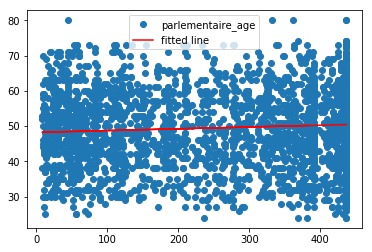

In [73]:
tt = {}
for i in tous_collaborateurs.drop(["emploi_rotation_six_mois", "emploi_taux_depart_six_mois", "emploi_taux_arrivee_six_mois", "contrat_present_a_date_rotation_six_premiers_mois_y", "contrat_entree_depuis_date_rotation_six_premiers_mois_y", "contrat_sortie_depuis_date_rotation_six_premiers_mois_y", "emploi_rotation_six_premiers_mois", "emploi_taux_depart_six_premiers_mois", "emploi_taux_arrivee_six_premiers_mois", "contrat_sortie_depuis_date_rotation_six_mois_y", "contrat_entree_depuis_date_rotation_six_mois_y", "contrat_present_a_date_rotation_six_mois_y", "emploi_taux_arrivee_un_an", "emploi_taux_depart_un_an", "emploi_rotation_un_an", "contrat_present_moyen", "contrat_sortie_depuis_date_rotation_un_an_y", "contrat_entree_depuis_date_rotation_un_an_y", "contrat_present_a_date_rotation_un_an_y", "ratio_contrat_mandat", "contrat_fini_min", "ancien_depute", "nb_mandats", "groupes_majoritaires", "nb_collaborateurs_total", "parlementaire_femme", "parlementaire_homme", "parlementaire_has_autre_mandats", "groupe_MODEM", "groupe_LR", "groupe_LREM", "groupe_UAI", "groupe_NG", "groupe_NI", "groupe_LFI", "groupe_GDR", "collaborateur_femme", "collaborateur_homme", "contrat_fini", "contrat_plus_de_2_mois", "contrat_plus_de_4_mois", "contrat_plus_de_6_mois", "contrat_present_a_date_rotation_un_an_x", "contrat_entree_depuis_date_rotation_un_an_x", "contrat_sortie_depuis_date_rotation_un_an_x", "contrat_present_a_date_rotation_six_mois_x", "contrat_entree_depuis_date_rotation_six_mois_x", "contrat_sortie_depuis_date_rotation_six_mois_x", "contrat_present_a_date_rotation_six_premiers_mois_x", "contrat_entree_depuis_date_rotation_six_premiers_mois_x", "contrat_sortie_depuis_date_rotation_six_premiers_mois_x", "contrat_max", "contrat_min", "nb_contrats_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "nb_contrat_fini", "ratio_contrat_fini", "contrat_fini_max", "nombredejours", "contrat_moyenne", "contrat_mediane", "ratio_plus_de_2_mois","ratio_plus_de_4_mois","ratio_plus_de_6_mois"], 1).columns[24:]:
    tt[i] = linregress(tous_collaborateurs["nombredejours"], tous_collaborateurs[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(tous_collaborateurs["nombredejours"], tous_collaborateurs[i], 'o', label=i)
        plt.plot(tous_collaborateurs["nombredejours"], tt[i].intercept + tt[i].slope*tous_collaborateurs["nombredejours"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")

Un modèle de regression logit existe et test la correlation et l'effet des variables entre elles. Il confirme les résultats ci-dessus

[Il est là !](https://github.com/regardscitoyens/Collaborateurs-Parlement/blob/master/exploitations/script_R_collaborateurs)

# Effet de la temporalité des fins de contrats

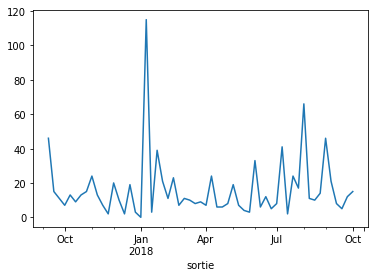

In [35]:
csv.index = csv["sortie"]
csv[csv.index != max(csv["sortie"])].resample('W').count()["collaborateur"].plot()

In [36]:
csv[csv.index != max(csv["sortie"])].resample('D').count()["collaborateur"].sort_values(ascending=False).head(20)

sortie
2018-01-09    105
2017-09-05     40
2018-09-02     38
2018-08-02     34
2018-01-26     33
2018-07-02     29
2018-06-02     20
2018-07-20     19
2018-02-17     18
2018-04-02     17
2018-02-02     15
2018-10-02     15
2018-08-05     13
2017-11-02     12
2017-12-02     11
2018-05-02     11
2018-03-02      8
2018-08-03      8
2017-10-21      8
2017-12-23      8
Name: collaborateur, dtype: int64

## hypothèse : janvier = fin des contrats familiaux

Impossible à détecter de manière systématique. Nécessite un travail d'enquête.

Sous hypothèses :
 
 - lié au changement autre que contrats familiaux (incompatibilité professionnelle, ...)
 - emploi familiaux de personne ne partageant pas le même patronyme
 - non lié au changement de règlementattion

In [39]:
janvier = csv[(csv["sortie"] >= '2018-01-01 00:00:00') & (csv["sortie"] <= '2018-01-15 00:00:00')]
janvier[janvier["nom_parlementaire"] == janvier["nom_collaborateur"]]["sortie"]

Series([], Name: sortie, dtype: datetime64[ns])

## hypothèse : LREM et benalla

Le ratio des départs des collaborateurs provenant d'un groupe majoritaire par rapport à l'ensemble des départ laisse entendre que ces évènements sont-il liés à l'appartenance à un groupe majoritaire.

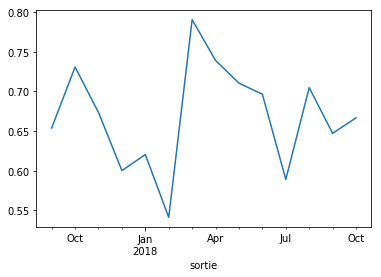

In [38]:
(csv[(csv.index != max(csv["sortie"])) & (csv['groupes_majoritaires'])].resample('M').count()["nom_parlementaire"] / csv[csv.index != max(csv["sortie"])].resample('M').count()["nom_parlementaire"]).plot()


Il y a un 63% de LREM, les deux évènements marquants : Janvier (changement de règlementation) et Juillet (Benalla) sont les évènement qui ont plus touché les parlementaires non issus de la majorité.

Il n'y a donc pas d'effet Benalla.

# Des effets individuels ?

### Rotation de l'emploi

Pour mesurer les effets du comportement individuel des députés, nous devons nous intéresser à la question des collaborateurs au sein d'une équipe. On peut donc dans ce cas considérer l'équipe d'un député comme une PME.

La rotation de l'emploi moyenne des collaborateurs d'un député est de 53%. Au niveau national, elle est de 58,8% dans les établissements de 1 à 9 salariés d'après une étude de la [DARES de 2011](http://travail-emploi.gouv.fr/IMG/pdf/2012-056.pdf).

Pour limiter les effets de bords liés à député qui avait peut de collaborateur en octobre 2017 et qui ont recruté en cours d'année, le calcul de la rotation de l'emploi est modifiée pour que le ratio ne soit pas basé sur le nombre en début de période mais la moyenne sur la période.

La répartition par quartile et la visualisation de la distribution montrent en revanche que 25% des députés ont une rotation d'emploi nettemment au dessus de la moyenne nationale (> 100% de taux de rotation).

=> 25% ont renouvelé leur staff de 1 à 3 fois

In [46]:
duree_collaborateurs[duree_collaborateurs["emploi_rotation_un_an"] < 100]["emploi_rotation_un_an"].describe()

count    564.000000
mean       0.619028
std        0.526014
min        0.000000
25%        0.200000
50%        0.500000
75%        1.000000
max        3.000000
Name: emploi_rotation_un_an, dtype: float64

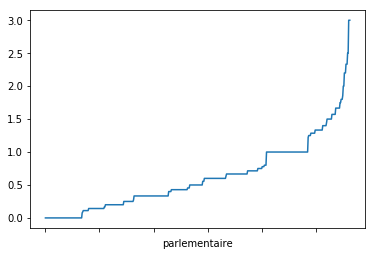

In [47]:
duree_collaborateurs.sort_values("emploi_rotation_un_an").set_index("parlementaire")["emploi_rotation_un_an"].plot()
#duree_collaborateurs["emploi_rotation"].plot()

## Comportements du dernier quartile

### La rotation d'emploi permet-elle de le comprendre ?

rotation de l'emploi sur un an le plus fort, permet d'identifier des parlementaires qui ont un fort taux de départ et d'arrivée. Il fait aussi remonter des parlementaires qui n'avaient pas de staff en octobre 2017 (début de la période étudée)


In [48]:
duree_collaborateurs.sort_values(["emploi_rotation_un_an","emploi_rotation_six_mois",'emploi_taux_depart_un_an'], ascending=False)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "emploi_rotation_un_an",'contrat_entree_depuis_date_rotation_un_an', 'contrat_sortie_depuis_date_rotation_un_an','contrat_present_moyen', "nb_collaborateurs_total", "nb_contrat_fini","emploi_taux_arrivee_un_an","emploi_taux_depart_un_an"]].head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,emploi_rotation_un_an,contrat_entree_depuis_date_rotation_un_an,contrat_sortie_depuis_date_rotation_un_an,contrat_present_moyen,nb_collaborateurs_total,nb_contrat_fini,emploi_taux_arrivee_un_an,emploi_taux_depart_un_an
95,Sonia Krimi,LREM,F,Manche,3.000000,7.0,5.0,2.0,9,6.0,3.500000,2.500000
213,Pierre Vatin,LR,H,Oise,3.000000,6.0,3.0,1.5,6,3.0,4.000000,2.000000
62,José Evrard,NI,H,Pas-de-Calais,3.000000,7.0,5.0,2.0,8,5.0,3.500000,2.500000
24,Anne-France Brunet,LREM,F,Loire-Atlantique,2.500000,5.0,5.0,2.0,8,6.0,2.500000,2.500000
7,Jérôme Nury,LR,H,Orne,2.500000,7.0,3.0,2.0,7,3.0,3.500000,1.500000
231,Barbara Bessot Ballot,LREM,F,Haute-Saône,2.333333,3.0,4.0,1.5,5,4.0,2.000000,2.666667
114,Michel Vialay,LR,H,Yvelines,2.333333,4.0,3.0,1.5,5,3.0,2.666667,2.000000
529,Jean-Michel Mis,LREM,H,Loire,2.333333,5.0,2.0,1.5,5,2.0,3.333333,1.333333
5,Valérie Rabault,NG,F,Tarn-et-Garonne,2.200000,6.0,5.0,2.5,8,5.0,2.400000,2.000000
27,Alexandre Freschi,LREM,H,Lot-et-Garonne,2.200000,6.0,5.0,2.5,8,5.0,2.400000,2.000000


### Et le nombre de contrats terminés ?

Trier les parlementaires par la proportion de contrats clos parmis tous leurs contrats de collaborateur (contrats très courts et parlementaires nouvellement élus exclus)

Incomplet car ceux qui viennent de "perdre" l'intégralité de leur staff remontent par rapport à ceux qui perdent régulièrement leur staff : cas de Aude Bono qui a perdu ressemment tout son staff.

In [49]:
duree_collaborateurs.sort_values('ratio_contrat_fini', ascending=False)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "ratio_contrat_fini", "nb_collaborateurs_total", "nb_contrat_fini"]].head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,ratio_contrat_fini,nb_collaborateurs_total,nb_contrat_fini
343,Aude Bono-Vandorme,LREM,F,Aisne,1.000000,5,5.0
231,Barbara Bessot Ballot,LREM,F,Haute-Saône,0.800000,5,4.0
478,Bérangère Abba,LREM,F,Haute-Marne,0.800000,5,4.0
28,Danièle Hérin,LREM,F,Aude,0.750000,8,6.0
24,Anne-France Brunet,LREM,F,Loire-Atlantique,0.750000,8,6.0
87,Richard Ramos,MODEM,H,Loiret,0.750000,4,3.0
6,Danielle Brulebois,LREM,F,Jura,0.727273,11,8.0
136,Sira Sylla,LREM,F,Seine-Maritime,0.727273,11,8.0
51,Laëtitia Romeiro Dias,LREM,F,Essonne,0.714286,7,5.0
55,Aude Amadou,LREM,F,Loire-Atlantique,0.714286,7,5.0


### Le taux de départ

le nombre de départs sur un an / le nombre moyen de collaborateur (entre octobre 2017 et 2018)

quand il y a un emploi_taux_depart_six_mois beaucoup plus petit à emploi_taux_depart_six_premiers_mois, c'est que la situation s'est stabilitée dans les derniers mois (lié à une difficulté de recrutement, par exemple)

Les 50 députés ayant un taux de départ le plus élevés ont tous un taux de rotation > 1 (=> font parti du quartile problèmatique)

In [78]:
duree_collaborateurs.sort_values(['emploi_taux_depart_un_an',"emploi_taux_depart_six_mois"], ascending=False)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "emploi_taux_depart_un_an", "emploi_taux_depart_six_mois", "emploi_taux_depart_six_premiers_mois", 'emploi_rotation_un_an', "contrat_sortie_depuis_date_rotation_un_an", 'contrat_present_moyen']].head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,emploi_taux_depart_un_an,emploi_taux_depart_six_mois,emploi_taux_depart_six_premiers_mois,emploi_rotation_un_an,contrat_sortie_depuis_date_rotation_un_an,contrat_present_moyen
231,Barbara Bessot Ballot,LREM,F,Haute-Saône,2.666667,1.000000,1.0,2.333333,4.0,1.5
343,Aude Bono-Vandorme,LREM,F,Aisne,2.500000,1.000000,0.0,1.500000,5.0,2.0
95,Sonia Krimi,LREM,F,Manche,2.500000,0.750000,2.0,3.000000,5.0,2.0
24,Anne-France Brunet,LREM,F,Loire-Atlantique,2.500000,0.600000,1.0,2.500000,5.0,2.0
62,José Evrard,NI,H,Pas-de-Calais,2.500000,0.500000,3.0,3.000000,5.0,2.0
136,Sira Sylla,LREM,F,Seine-Maritime,2.000000,1.333333,0.8,1.750000,8.0,4.0
5,Valérie Rabault,NG,F,Tarn-et-Garonne,2.000000,1.000000,1.0,2.200000,5.0,2.5
27,Alexandre Freschi,LREM,H,Lot-et-Garonne,2.000000,1.000000,1.0,2.200000,5.0,2.5
51,Laëtitia Romeiro Dias,LREM,F,Essonne,2.000000,1.000000,1.0,1.800000,5.0,2.5
213,Pierre Vatin,LR,H,Oise,2.000000,0.750000,NaN,3.000000,3.0,1.5


In [51]:
# données pour Rozenn
duree_collaborateurs[duree_collaborateurs['parlementaire'].isin(["Valérie Petit", "José Evrard", "Anissa Khedher", "Thomas Gassilloud", "Anne-France Brunet", "Aude Amadou", "Alexandre Freschi"])].to_csv("../rozenn.csv")

## Hypothèse : une erreur de casting

A quel point ce taux de rotation est lié à des "erreurs de casting" en début de législature ?

Comparons le taux de rotation sur les six derniers mois :

In [33]:
(((csv["contrat_entree_depuis_date_rotation_six_mois"]*1).sum()+(csv["contrat_sortie_depuis_date_rotation_six_mois"]*1).sum())/2)/((csv["contrat_present_a_date_rotation_six_mois"]*1).sum())

0.23283811475409835

sur les six premiers mois :

In [34]:
(((csv["contrat_entree_depuis_date_rotation_six_premiers_mois"]*1).sum()+(csv["contrat_sortie_depuis_date_rotation_six_premiers_mois"]*1).sum())/2)/((csv["contrat_present_a_date_rotation_six_premiers_mois"]*1).sum())

0.37030075187969924

Il y aurait un effet "début de législature" au vu de ce résultat.

Construisons un indicateur permettant d'identifier des éventuels "erreurs de casting" dans le dernier quartile :

In [105]:
#Pas de infini ou de division par zero
duree_collaborateurs["emploi_taux_depart_six_mois"] += 0.00000001
duree_collaborateurs["indicateur_casting"] = duree_collaborateurs["emploi_taux_depart_six_premiers_mois"] / duree_collaborateurs["emploi_taux_depart_six_mois"]
duree_collaborateurs["effet_casting"] = (duree_collaborateurs["indicateur_casting"] > 2)

In [107]:
duree_collaborateurs.sort_values(['emploi_taux_depart_un_an',"emploi_taux_depart_six_mois"], ascending=False)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "emploi_taux_depart_un_an", 'effet_casting', "emploi_taux_depart_six_mois", "emploi_taux_depart_six_premiers_mois", 'emploi_rotation_un_an', "contrat_sortie_depuis_date_rotation_un_an", 'contrat_present_moyen']].head(50)


,parlementaire,groupe_sigle,sexe_parlementaire,departement,emploi_taux_depart_un_an,effet_casting,emploi_taux_depart_six_mois,emploi_taux_depart_six_premiers_mois,emploi_rotation_un_an,contrat_sortie_depuis_date_rotation_un_an,contrat_present_moyen
231,Barbara Bessot Ballot,LREM,F,Haute-Saône,2.666667,False,1.000000e+00,1.000000e+00,2.333333,4.0,1.5
343,Aude Bono-Vandorme,LREM,F,Aisne,2.500000,False,1.000000e+00,1.000000e-08,1.500000,5.0,2.0
95,Sonia Krimi,LREM,F,Manche,2.500000,True,7.500001e-01,2.000000e+00,3.000000,5.0,2.0
24,Anne-France Brunet,LREM,F,Loire-Atlantique,2.500000,False,6.000001e-01,1.000000e+00,2.500000,5.0,2.0
62,José Evrard,NI,H,Pas-de-Calais,2.500000,True,5.000001e-01,3.000000e+00,3.000000,5.0,2.0
136,Sira Sylla,LREM,F,Seine-Maritime,2.000000,False,1.333333e+00,8.000000e-01,1.750000,8.0,4.0
5,Valérie Rabault,NG,F,Tarn-et-Garonne,2.000000,False,1.000000e+00,1.000000e+00,2.200000,5.0,2.5
27,Alexandre Freschi,LREM,H,Lot-et-Garonne,2.000000,False,1.000000e+00,1.000000e+00,2.200000,5.0,2.5
51,Laëtitia Romeiro Dias,LREM,F,Essonne,2.000000,False,1.000000e+00,1.000000e+00,1.800000,5.0,2.5
213,Pierre Vatin,LR,H,Oise,2.000000,False,7.500001e-01,NaN,3.000000,3.0,1.5


30% des parlementaires du dernier quartile ont eu un effet casting : ils ont vu leur taux de départ amélioré lors du 2d semestre :

In [115]:
(duree_collaborateurs[(duree_collaborateurs["emploi_rotation_un_an"] >= 1) & duree_collaborateurs["effet_casting"]].count() / duree_collaborateurs[duree_collaborateurs["emploi_rotation_un_an"] >= 1].count())["parlementaire"]*100

29.677419354838708

## Conclusions

On observe une rotation du travail moyenne à l'échelle de l'Assemblée comparable au taux moyen français pour les entreprises de petite taille. Malgré cela, certains parlementaires ont un taux sensiblement au-dessus de la moyenne.

Nous avons isolé des parlementaires dont le taux de rotation de l'emploi est le plus haut grâce à des critères descriptifs simples basés sur les temps de contrats des collaborateurs et leur nombre de collaborateurs.

Une série de tests statistiques nous a permis de mesurer l'effet de différentes caractéristiques des parlementaires (sexe, âge, groupe politique, etc...) sur la durée médiane des contrats de leurs collaborateurs.

Des profils de managers et d'employés émergent de notre analyse des données collectées depuis le 22 juin 2017. La présence de collaborateurs fidèles, l'influence du sexe, de l'âge ou de l'ancienneté du parlementaire sur la durée des collaborations, ou encore la propension des groupes LREM et NI a se séparer plus rapidement de leur collaborateurs méritent d'être étudiés plus en détails. Notamment à la lumière d'informations complémentaires sur la teneur des contrats des collaborateurs parlementaires.